In [ ]:
# %pip install xlrd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [46]:
# load
df_RP = pd.read_csv("./data/regression_data_RP.csv")
df_EN = pd.read_csv("./data/regression_data_EN.csv")

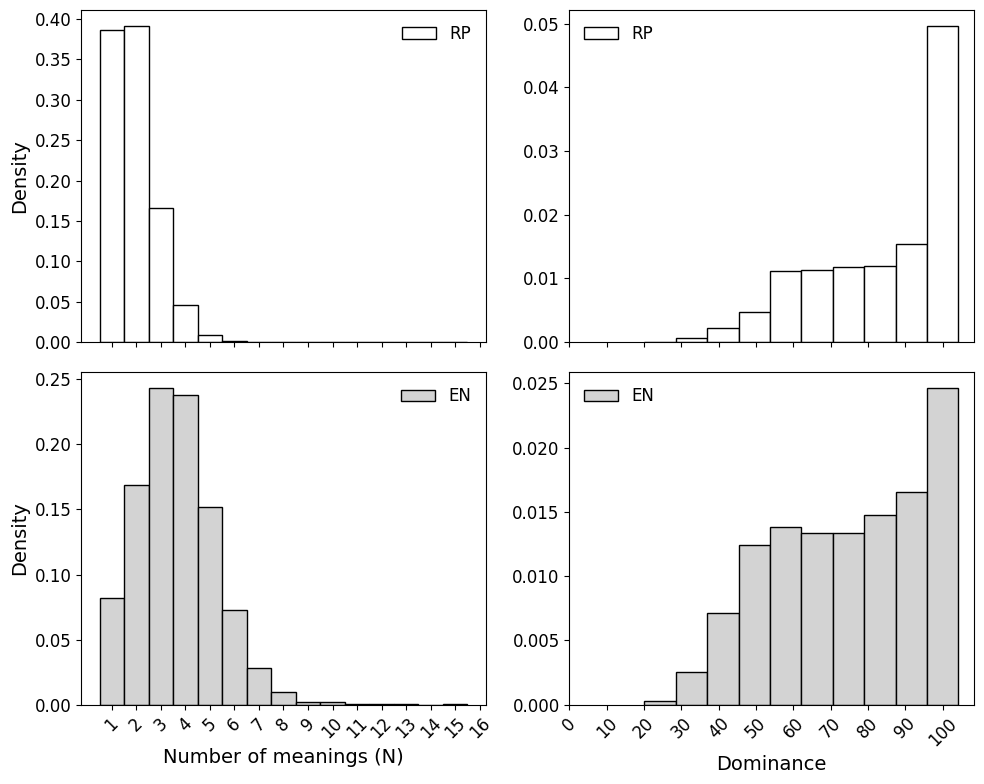

In [ ]:
# function to (optionally) create frequency stratified samples for dataframes 
def sample_df(df, n, stratified=False, strat_col=None, q=5):
  if stratified and strat_col is not None and strat_col in df.columns:
    cuts = pd.qcut(df[strat_col], q=q)
    cut_n = n // q
    idxs = []
    for cut in cuts.unique():
      sub_cuts = cuts[cuts==cut]
      idxs.extend(sub_cuts.sample(cut_n).index.to_list())
    return df.iloc[idxs]
  else:
    return df.sample(n)
  
# Fig 2
# --------------------------------------------------------------------------------
n_communities_min = min(df_RP['n_communities'].min(), df_EN['n_communities'].min())
n_communities_max = max(df_RP['n_communities'].max(), df_EN['n_communities'].max())

max_dom_min = min(df_RP['max_dom'].min(), df_EN['max_dom'].min())
max_dom_max = max(df_RP['max_dom'].max(), df_EN['max_dom'].max())

df_RP['max_dom_scaled'] = df_RP['max_dom'] * 100
df_EN['max_dom_scaled'] = df_EN['max_dom'] * 100

n_communities_bins = np.arange(n_communities_min, n_communities_max + 1)  # +1 to include the upper edge
max_dom_bins = np.linspace(max_dom_min * 100, max_dom_max * 100, 11)  # 10 bins, scaled to 0-100

plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex='col') # sharey removed

axes[0, 0].hist(df_RP['n_communities'], bins=n_communities_bins, density=True, color='white', edgecolor='black', align='left', label='RP')
axes[0, 1].hist(df_RP['max_dom_scaled'], bins=max_dom_bins, density=True, color='white', edgecolor='black', align='right', label='RP')
axes[1, 0].hist(df_EN['n_communities'], bins=n_communities_bins, density=True, color='lightgrey', edgecolor='black', align='left', label='EN')
axes[1, 1].hist(df_EN['max_dom_scaled'], bins=max_dom_bins, density=True, color='lightgrey', edgecolor='black', align='right', label='EN')

for ax, x_label, y_label in zip(
    axes.flatten(),
    ["", "", "Number of meanings (N)", "Dominance"],
    ["Density", "", "Density", ""]
):
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

for ax in [axes[0, 0], axes[1, 0]]:
    ax.set_xticks(np.arange(n_communities_min, n_communities_max + 1))
    ax.set_xticklabels(np.arange(n_communities_min, n_communities_max + 1))

for ax in [axes[0, 1], axes[1, 1]]:
    ax.set_xticks(np.arange(0, 101, 10))
    ax.set_xticklabels(np.arange(0, 101, 10))

for ax in axes.flatten():
    ax.tick_params(axis='x', labelrotation=45)


for ax in [axes[0, 1], axes[1, 1]]:
    ax.set_ylim(bottom=0)

axes[0, 0].legend(loc='upper right', frameon=False)
axes[0, 1].legend(loc='upper left', frameon=False)
axes[1, 0].legend(loc='upper right', frameon=False)
axes[1, 1].legend(loc='upper left', frameon=False)


plt.tight_layout()
plt.show()


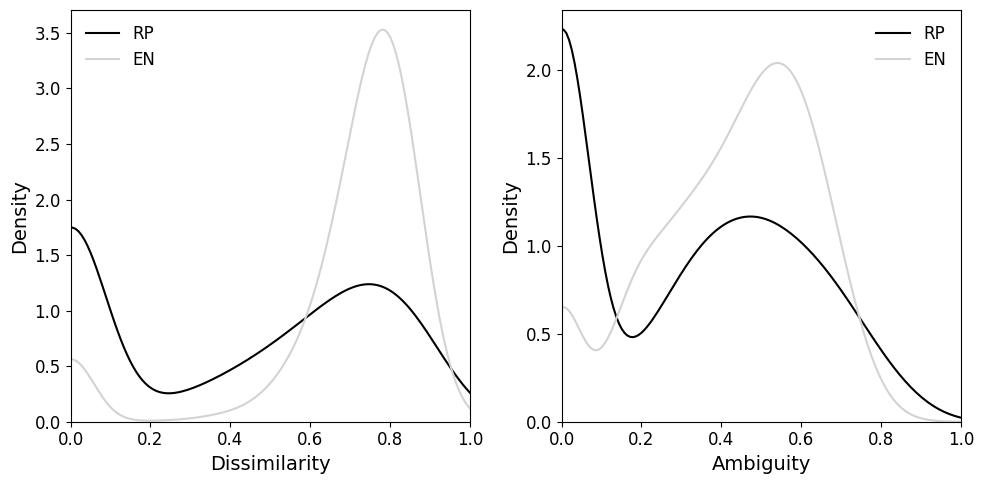

In [ ]:
# Fig 3
# --------------------------------------------------------------------------------
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})

fig, axes = plt.subplots(1, 2, figsize=(10,5))

sns.kdeplot(df_RP["dissimilarity"], color="black", label="RP", bw_adjust=1.5, ax=axes[0])
sns.kdeplot(df_EN["dissimilarity"], color="lightgrey", label="EN", bw_adjust=1.5, ax=axes[0])
axes[0].set_xlim(0, 1)
axes[0].set_xlabel("Dissimilarity")
axes[0].legend(frameon=False)

sns.kdeplot(df_RP["ambiguity"], color="black", label="RP", bw_adjust=1.5, ax=axes[1])
sns.kdeplot(df_EN["ambiguity"], color="lightgrey", label="EN", bw_adjust=1.5, ax=axes[1])
axes[1].set_xlim(0, 1)
axes[1].set_xlabel("Ambiguity")
axes[1].legend(frameon=False)

plt.tight_layout()
plt.show()

In [80]:

# Fig 6
# --------------------------------------------------------------------------------
armstrong_data = pd.read_csv('./data/armstrong_data_EN.csv')
tmp = pd.merge(df_EN[['word','dissimilarity']], armstrong_data[['word','mean_rel']], how='inner')
tmp['similarity'] = 1 - tmp['dissimilarity'] # convert to similarity
tmp = tmp[tmp['similarity'] < 1]
tmp['relatedness'] = tmp['mean_rel']/7 # normalize
compare_to_armstrong_df = tmp.drop(columns=['dissimilarity','mean_rel'])

haro_data = pd.read_excel('./data/haro_data_RP.xls')
tmp = pd.merge(df_RP[['word','dissimilarity']], haro_data[['word','ROM1']], how='inner')
tmp['similarity'] = 1 - tmp['dissimilarity'] # convert to similarity
tmp = tmp[tmp['similarity'] < 1]
tmp['ROM'] = tmp['ROM1']/9 # normalize
compare_to_haro_df = tmp.drop(columns=['dissimilarity','ROM1'])


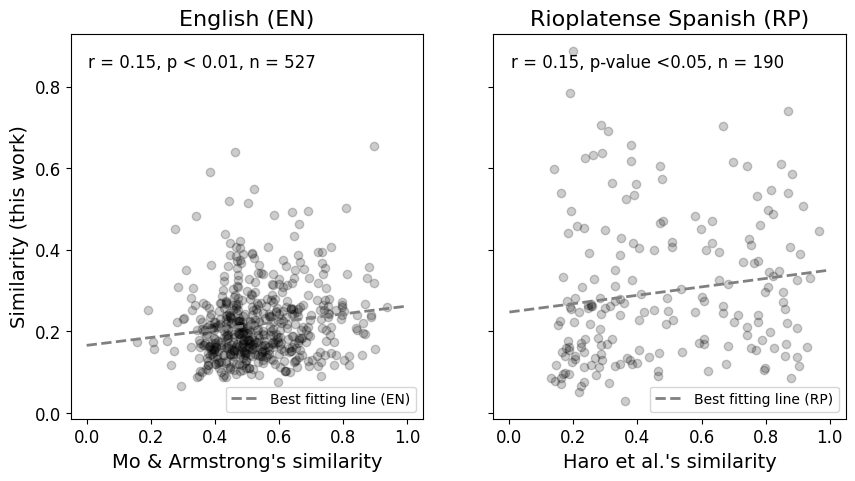

In [ ]:
# Pearson's
r1, p1 = pearsonr(compare_to_armstrong_df['relatedness'], compare_to_armstrong_df['similarity'])
n1 = len(compare_to_armstrong_df)

r2, p2 = pearsonr(compare_to_haro_df['ROM'], compare_to_haro_df['similarity'])
n2 = len(compare_to_haro_df)

# regression lines
slope1, intercept1 = np.polyfit(compare_to_armstrong_df['relatedness'], compare_to_armstrong_df['similarity'], 1)
slope2, intercept2 = np.polyfit(compare_to_haro_df['ROM'], compare_to_haro_df['similarity'], 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# comparing to Armstrong (EN)
x_vals = np.array(axes[0].get_xlim())
y_vals = slope1 * x_vals + intercept1
axes[0].plot(x_vals, y_vals, color='gray', linewidth=2, linestyle='--', label='Best fitting line (EN)')
axes[0].legend(fontsize=10, loc='lower right')

axes[0].scatter(compare_to_armstrong_df['relatedness'], compare_to_armstrong_df['similarity'], color='k', alpha=0.2)
axes[0].set_title('English (EN)', fontsize=16)
axes[0].set_xlabel('Mo & Armstrong\'s similarity', fontsize=14)
axes[0].set_ylabel('Similarity (this work)', fontsize=14)
axes[0].text(0.05, 0.95,
             f"r = {r1:.2f}, p < 0.01, n = {n1}",
             transform=axes[0].transAxes,
             verticalalignment='top',
             fontsize=12)

# comparing to Haro (RP)
x_vals = np.array(axes[1].get_xlim())
y_vals = slope2 * x_vals + intercept2
axes[1].plot(x_vals, y_vals, color='gray', linewidth=2, linestyle='--', label='Best fitting line (RP)')
axes[1].legend(fontsize=10, loc='lower right')

axes[1].scatter(compare_to_haro_df['ROM'], compare_to_haro_df['similarity'], color='k', alpha=0.2)
axes[1].set_title('Rioplatense Spanish (RP)', fontsize=16)
axes[1].set_xlabel('Haro et al.\'s similarity', fontsize=14)
axes[1].text(0.05, 0.95,
             f"r = {r2:.2f}, p-value <0.05, n = {n2}",
             transform=axes[1].transAxes,
             verticalalignment='top',
             fontsize=12)


# plt.tight_layout()
plt.show()
